# <center> SABR calibration </center>

$$ df_t = \alpha_t f_t^ dW_t^1\beta $$ 
$$ d \alpha_t = v \alpha_t f_t^ dW_t^2$$ 
$$E[dW_t^1, dW_t^2] = \rho dt$$

$$\sigma_B = \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(fK)^{1-\beta}} + \frac{\rho \beta v \alpha}{4(fK)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}v^2]T)}{(fK)^{(1-\beta)/2}[1+\frac{(1-\beta)^2}{24} \ln{(\frac{f}{K})}^2 + \frac{(1-\beta)^4}{1920} \ln{(\frac{f}{K})}^4]} * \frac{z}{\xi(z)}$$
$$z = \frac{v}{\alpha}(fK)^{(1-\beta)/2}\ln{(f/K)^2}$$
$$\xi(z) = \ln{[\frac{\sqrt{1-2z\rho+z^2}+z-\rho}{1-\rho}]}$$

Finding $\beta$:
$$\sigma_{ATM} = \sigma_{B} (f, f) =  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$

$$\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}$$

$$ \ln \alpha - (1 - \beta) \ln {f} \sim \sigma^{market} $$


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")
from matplotlib.pyplot import figure
from importlib import reload
import sys
import src.SABR.sabr_approx
reload(src.SABR.sabr_approx)
from sklearn.linear_model import LinearRegression
from src.SABR.sabr_approx import calibrate_sabr
from src.utils import process_data, round_params
import datetime
import warnings
warnings.filterwarnings("ignore")
import h5py
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [115]:
%%time
raw = pd.HDFStore('datasets/eth-20230224.h5','r').get("/eth")
# raw2 = pd.HDFStore('../datasets/eth-20230127.h5','r').get("/eth")
# raw3 = pd.HDFStore('../datasets/eth-20230310.h5','r').get("/eth")
# raw = pd.concat([raw1, raw2, raw3]).drop_duplicates()
# raw.dt.hist(bins = 100)

In [4]:
%%time
df = process_data(raw)
df.head()

CPU times: user 51.1 s, sys: 25.7 s, total: 1min 16s
Wall time: 2min 10s


,dt,mark_price,instrument,type,strike_price,expiration,underlying_price,timestamp
0,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-1700-C,call,1700,1669334400000000,1133.9,1669036104511000
1,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-2400-C,call,2400,1669334400000000,1133.9,1669036104511000
2,2022-11-21 13:08:24.511,0.0020,ETH-25NOV22-700-P,put,700,1669334400000000,1133.9,1669036104511000
3,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3800-C,call,3800,1669334400000000,1133.9,1669036104511000
4,2022-11-21 13:08:24.511,0.0005,ETH-25NOV22-3400-C,call,3400,1669334400000000,1133.9,1669036104511000


# Params dynamics

In [66]:
%%time
number_of_dots = 150
timestamps_hm = []

params_all = []
params_beta = []

errors_all = []
errors_beta = []

alpha = np.float64(1.0)
v = np.float64(1.3)
beta = np.float64(0.9)  
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

# Get ticks with similar distnce from available data
calibr_borders = df[(df["dt"] >= "2023-02-04") & (df["dt"] <= "2023-02-04 23:00:00")].copy()
df_only_exp = calibr_borders[calibr_borders["expiration"] == calibr_borders.sample(1).expiration.iloc[0]].copy()

print("Optimize first params with random start once")
calibrated_params_all, first_error_all, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "all")
calibrated_params_beta, first_error_beta, _ = calibrate_sabr(df = df_only_exp, 
                                                        start_params = start_params, 
                                                        calibration_type = "beta", beta = 1.0)


print("All first calibrated:", round_params(calibrated_params_all), "error:", first_error_all)
print("Beta first calibrated:", round_params(calibrated_params_beta), "error:", first_error_beta)


timestamps = np.linspace(calibr_borders.timestamp.min(), calibr_borders.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    # zero params for each point are params from last step
    calibrated_params_all, error_all, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_all, 
                                timestamp = timestamp, calibration_type = "all")
#         print("All calibrated:", round_params(calibrated_params_all), "error:", error_all)

    calibrated_params_beta, error_beta, _ = calibrate_sabr(df = df_only_exp, start_params = calibrated_params_beta, 
                                timestamp = timestamp, calibration_type = "beta", beta = 1.0)
#         print("nu0 calibrated:", round_params(calibrated_params_beta), "error:", error_beta)

    params_all.append(calibrated_params_all)
    errors_all.append(error_all)
    params_beta.append(calibrated_params_beta)
    errors_beta.append(error_beta)
    timestamps_hm.append(timestamp)
        
#         print("    ")

timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps_hm]
params_all = np.array(params_all).T
params_beta = np.array(params_beta).T





Optimize first params with random start once
All first calibrated: [1.108, 4.693, 0.912, -0.099] error: 0.01069441204138896
Beta first calibrated: [0.591, 4.569, 1.0, -0.132] error: 0.010729646330994444


  0%|          | 0/150 [00:00<?, ?it/s]

CPU times: user 14.3 s, sys: 132 ms, total: 14.5 s
Wall time: 14.5 s


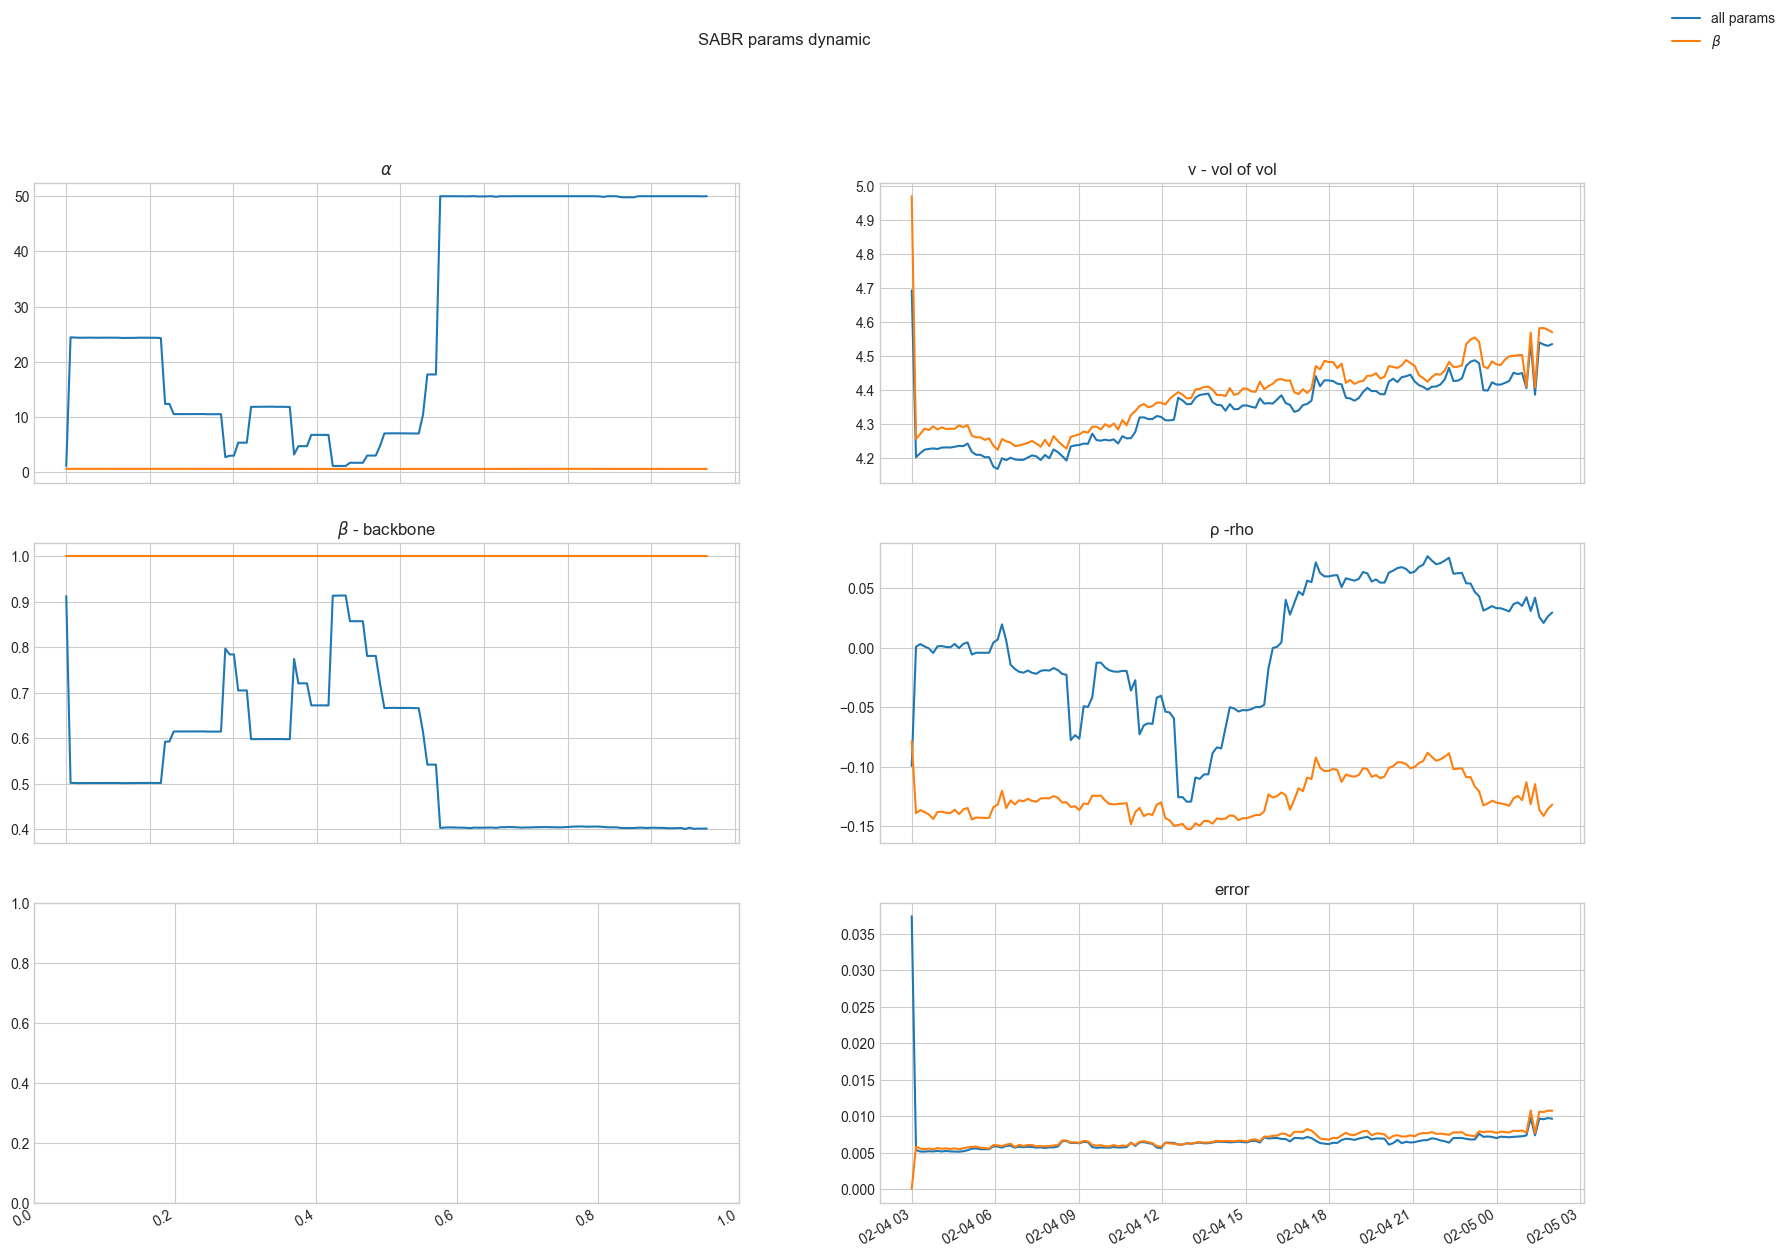

In [68]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(20, 15))

axs[0, 0].plot(timestamps_hm, params_all[0], label = "all params")
axs[0, 1].plot(timestamps_hm, params_all[1])
axs[1, 0].plot(timestamps_hm, params_all[2])
axs[1, 1].plot(timestamps_hm, params_all[3])
axs[2, 1].plot(timestamps_hm, errors_all)

axs[0, 0].plot(timestamps_hm, params_beta[0], label = r"$\beta$")
axs[0, 1].plot(timestamps_hm, params_beta[1])
axs[1, 0].plot(timestamps_hm, params_beta[2])
axs[1, 1].plot(timestamps_hm, params_beta[3])
axs[2, 1].plot(timestamps_hm, errors_beta)


axs[0, 0].set_title(r"$\alpha$")
axs[0, 1].set_title(r"v - vol of vol")
axs[1, 0].set_title(r"$\beta$ - backbone")
axs[1, 1].set_title("ρ -rho")
axs[2, 1].set_title("error")

plt.figlegend() 
fig.suptitle("SABR params dynamic")
plt.gcf().autofmt_xdate()
plt.show()

# Volatility smile

In [122]:
df_only_exp = df[df["expiration"] == df.sample(1).expiration.iloc[0]].copy()
needed_stamp = df_only_exp.sample(1).iloc[0].timestamp

In [123]:
alpha = np.float64(1.0) 
v = np.float64(1.3) 
beta = np.float64(0.9) 
rho = np.float64(-0.1) 

start_params = np.array([alpha, v, beta, rho])

pars_all, err_all, C_all = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "all")

pars_beta, err_beta, C_beta = calibrate_sabr(df = df_only_exp, 
                                          start_params = start_params, 
                                          timestamp = needed_stamp,
                                          calibration_type= "beta", beta = 1.0)

print("All:")
print(round_params(pars_all))
print(err_all)
print("   ")

print("Beta:")
print(round_params(pars_beta))
print(err_beta)


All:
[0.985, 7.678, 0.896, -0.044]
0.009488713497129144
   
Beta:
[0.478, 7.468, 1.0, -0.074]
0.00933551582493489


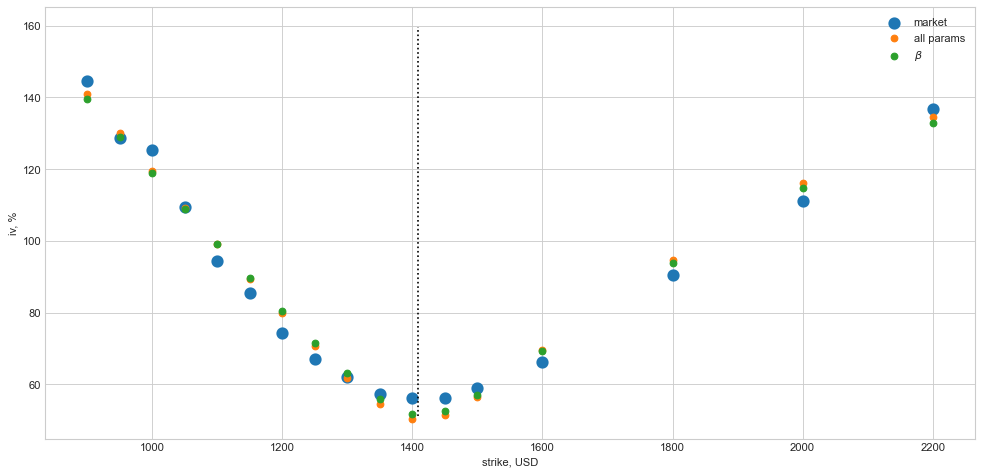

In [124]:
figure(figsize=(15, 7), dpi=80)

plt.scatter(C_all["strike_price"], C_all["iv"], label = "market", linewidths = 5)

# bid,ask iv
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["ask_iv"], '--', label = "ask_iv", color = "black")
# plt.plot(C_sing_exp_all["strike_price"], C_sing_exp_all["bid_iv"], '--', label = "bid_iv", color = "yellow")

plt.scatter(C_all["strike_price"], C_all["calibrated_iv"], label = "all params")
plt.scatter(C_beta["strike_price"], C_beta["calibrated_iv"], label = r"$\beta$")


plt.vlines([C_all.underlying_price.mean()], C_all.iv.min() - 5, 
           C_all.iv.max() + 15, color = "black", linestyles = "dotted")

plt.xlabel("strike, USD")
plt.ylabel("iv, %")
plt.legend()
plt.show()